# Simple Plotting


In [1]:
# RESULTS_PATH = "../../your_sweep_path/default"
RESULTS_PATH = "/tmp/results/default"

PLOT_ALL_SEEDS = False
# Full sweep
# MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl", "Qwen/Qwen-1_8B", "Qwen/Qwen-7B", "Qwen/Qwen-14B"]
# Minimal sweep
MODELS_TO_PLOT = ["gpt2", "gpt2-medium", "gpt2-large", "gpt2-xl"]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from IPython.display import display

import os
import glob
import json

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [159]:
records = []
for result_filename in glob.glob(os.path.join(RESULTS_PATH, "**/results_summary.json"), recursive=True):
    config_file = os.path.join("/".join(result_filename.split("/")[:-1]), "config_w2sg.json")
    try:
        config = json.load(open(config_file, "r"))
    except:
        print(f"Failed to load {config_file}")
        continue
    if config["model_size"] not in MODELS_TO_PLOT:
        continue
    if 'seed' not in config:
        config['seed'] = 0
    record = config.copy()
    if 'weak_model' in config:
        for k in record['weak_model']:
            if k == 'model_size':
                assert record['weak_model'][k] == record['weak_model_size']
            record['weak_' + k] = record['weak_model'][k]
        del record['weak_model']
    record.update(json.load(open(result_filename)))
    records.append(record)

df = pd.DataFrame.from_records(records).sort_values(['ds_name', 'model_size'])
df = df[df["ds_name"] == "sciq"].copy()
# add strong_model_accuracy column
strong_model_accuracies = {}
for model in df['model_size'].unique():
    accuracy = df[(df['model_size'] == model) & df['weak_model_size'].isnull()]['accuracy'].values[0]
    strong_model_accuracies[model] = accuracy

# Define a function to retrieve the strong_model_accuracy for each row
def get_strong_model_accuracy(row):
    return strong_model_accuracies.get(row['model_size'], float('nan'))

# Apply the function to create the new 'strong_model_accuracy' field
df['strong_model_accuracy'] = df.apply(get_strong_model_accuracy, axis=1)

def get_type(row):
    if row["strong_label_fraction"] == 0:
        return 'weak labels only'
    elif row['strong_label_fraction'] == 0.25 and row['shuffle_strong_labels'] == True and row['replace_least_confident'] != True and row['replace_most_incorrect'] != True:
        return '25% strong labels, shuffled'
    elif row["strong_label_fraction"] == 0.25 and row['shuffle_strong_labels'] == False:
        return '25% strong labels, strong before weak'
    elif row['strong_label_fraction'] == 0.25 and row['shuffle_strong_labels'] == True and row['replace_least_confident'] == True:
        return '25% strong labels, shuffled, replace least confident'
    elif row['strong_label_fraction'] == 0.25 and row['shuffle_strong_labels'] == True and row['replace_most_incorrect'] == True:
        return '25% strong labels, shuffled, replace most incorrect'
    elif row['strong_label_fraction'] == 0.10 and row['shuffle_strong_labels'] == True and row['replace_least_confident'] != True and row['replace_most_incorrect'] != True:
        return '10% strong labels, shuffled'
    elif row["strong_label_fraction"] == 0.10 and row['shuffle_strong_labels'] == False:
        return '10% strong labels, strong before weak'
    elif row['strong_label_fraction'] == 0.10 and row['shuffle_strong_labels'] == True and row['replace_least_confident'] == True:
        return '10% strong labels, shuffled, replace least confident'
    elif row['strong_label_fraction'] == 0.10 and row['shuffle_strong_labels'] == True and row['replace_most_incorrect'] == True:
        return '10% strong labels, shuffled, replace most incorrect'
    elif row['strong_label_fraction'] == 0.11 and row['shuffle_strong_labels'] == True and row['replace_least_confident'] != True and row['replace_most_incorrect'] != True:
        return '11% strong labels, shuffled'
    elif row["strong_label_fraction"] == 0.11 and row['shuffle_strong_labels'] == False:
        return '11% strong labels, strong before weak'
    elif row['strong_label_fraction'] == 0.11 and row['shuffle_strong_labels'] == True and row['replace_least_confident'] == True:
        return '11% strong labels, shuffled, replace least confident'
    elif row['strong_label_fraction'] == 0.11 and row['shuffle_strong_labels'] == True and row['replace_most_incorrect'] == True:
        return '11% strong labels, shuffled, replace most incorrect'
    else:
        return 'ground truth'

# Apply the function to create the new 'type' column
df['type'] = df.apply(get_type, axis=1)

In [160]:
# print model size, weak model size, accuracy
relevant_columns = ['model_size', 'weak_model_size', 'strong_model_accuracy', 'accuracy', 'stderr', 'strong_label_fraction', 'shuffle_strong_labels', 'replace_least_confident', 'replace_most_incorrect', 'type']
# sort by weak_model_size
df[relevant_columns].sort_values(['weak_model_size', 'model_size'])

,model_size,weak_model_size,strong_model_accuracy,accuracy,stderr,strong_label_fraction,shuffle_strong_labels,replace_least_confident,replace_most_incorrect,type
3,gpt2-large,gpt2,0.732,0.676,0.014799,0.25,False,NaN,NaN,"25% strong labels, strong before weak"
6,gpt2-large,gpt2,0.732,0.721,0.014183,0.10,True,NaN,True,"10% strong labels, shuffled, replace most inco..."
10,gpt2-large,gpt2,0.732,0.683,0.014714,0.11,False,NaN,NaN,"11% strong labels, strong before weak"
14,gpt2-large,gpt2,0.732,0.718,0.014229,0.10,True,NaN,NaN,"10% strong labels, shuffled"
32,gpt2-large,gpt2,0.732,0.680,0.014751,0.00,False,NaN,NaN,weak labels only
...,...,...,...,...,...,...,...,...,...,...
73,gpt2-xl,gpt2-medium,0.755,0.738,0.013905,0.25,True,NaN,True,"25% strong labels, shuffled, replace most inco..."
8,gpt2,NaN,0.647,0.647,0.015113,NaN,NaN,NaN,NaN,ground truth
63,gpt2-large,NaN,0.732,0.732,0.014006,NaN,NaN,NaN,NaN,ground truth
38,gpt2-medium,NaN,0.699,0.699,0.014505,NaN,NaN,NaN,NaN,ground truth


In [161]:
df[df["ds_name"] == "amazon_polarity"][relevant_columns]

,model_size,weak_model_size,strong_model_accuracy,accuracy,stderr,strong_label_fraction,shuffle_strong_labels,replace_least_confident,replace_most_incorrect,type


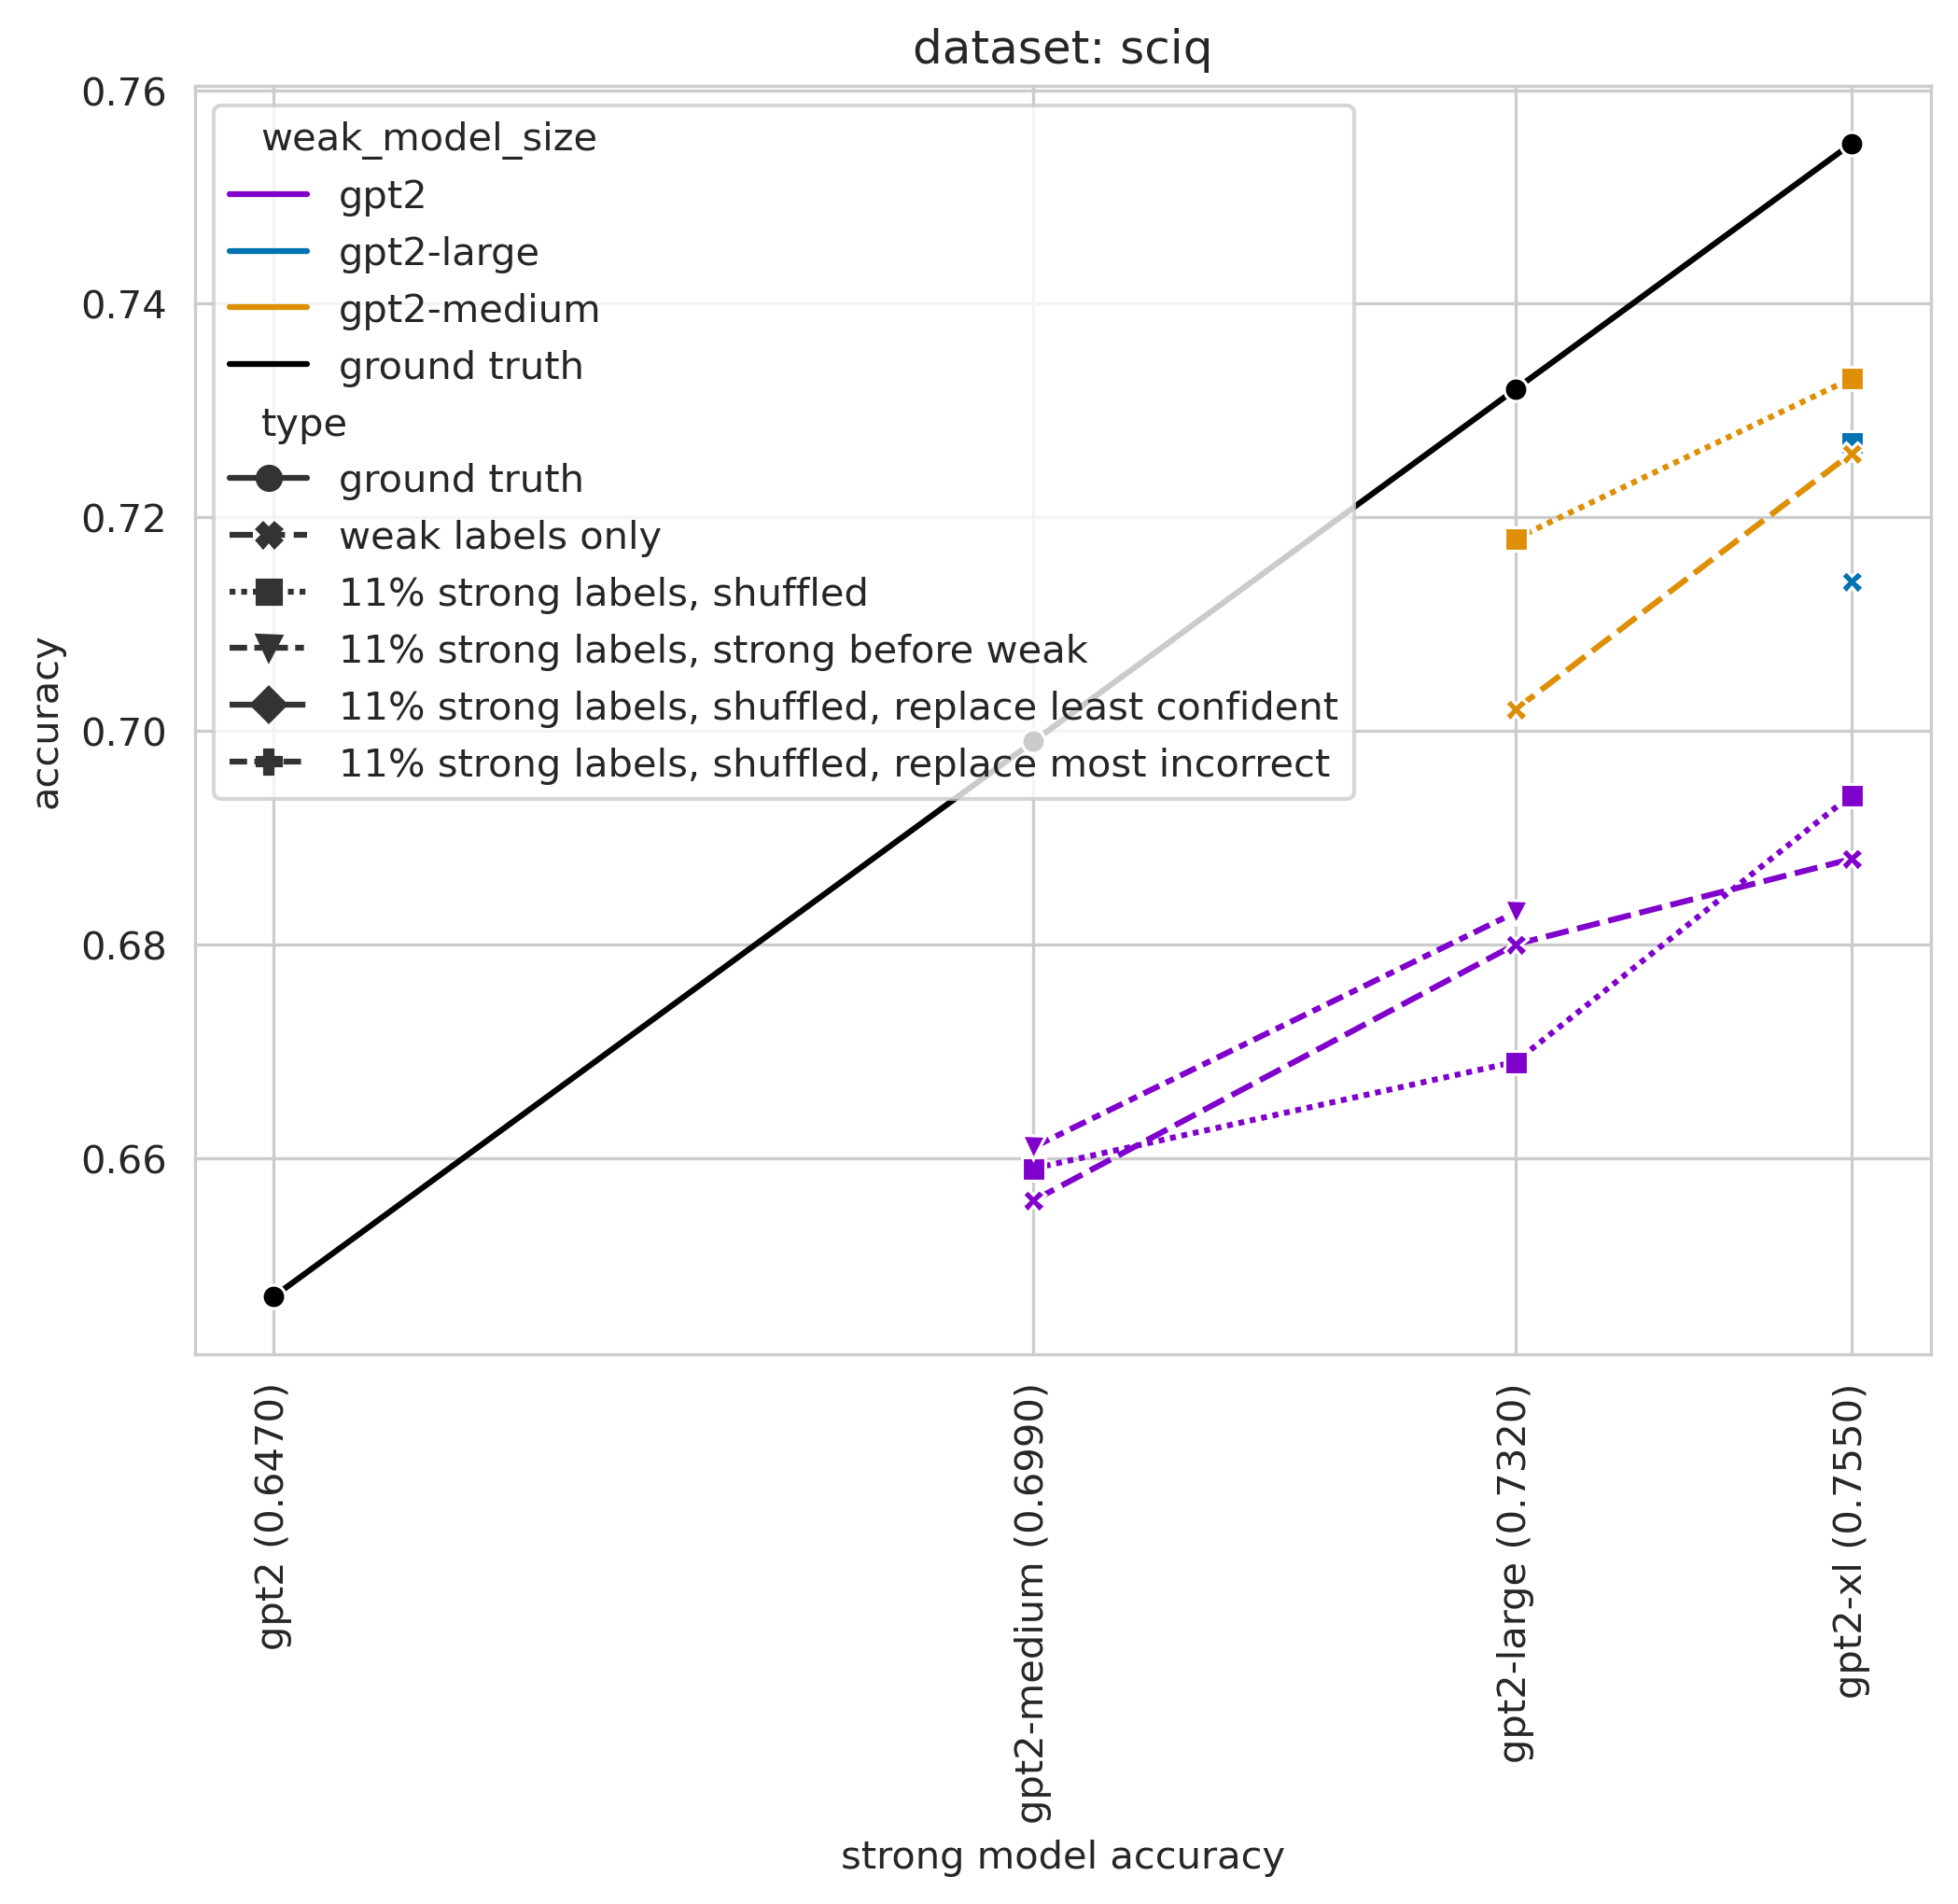

In [162]:
color_dict = {'ground truth': 'black',
 'gpt2': (0.5, 0, 0.8),
 'gpt2-xl': (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 'gpt2-medium': (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 'gpt2-large': (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)}

df_025 = df[(df['strong_label_fraction'] == 0.25) |
            (df['strong_label_fraction'] == 0) |
            (df['strong_label_fraction'].isna())].copy()
# fill in weak_model_size as "ground truth" where it is NaN
df_025['weak_model_size'] = df_025['weak_model_size'].fillna('ground truth')
# sort by "type" column
df_025['type'] = pd.Categorical(df_025['type'], ['ground truth', 'weak labels only', '25% strong labels, shuffled', '25% strong labels, strong before weak', '25% strong labels, shuffled, replace least confident', '25% strong labels, shuffled, replace most incorrect'])
df_025 = df_025.sort_values('type')
df_025 = df_025.sort_values('weak_model_size')


df_011 = df[(df['strong_label_fraction'] == 0.11) |
            (df['strong_label_fraction'] == 0) |
            (df['strong_label_fraction'].isna())].copy()
df_011['weak_model_size'] = df_011['weak_model_size'].fillna('ground truth')
df_011['type'] = pd.Categorical(df_011['type'], ['ground truth', 'weak labels only', '11% strong labels, shuffled', '11% strong labels, strong before weak', '11% strong labels, shuffled, replace least confident', '11% strong labels, shuffled, replace most incorrect'])
df_011 = df_011.sort_values('type')
df_011 = df_011.sort_values('weak_model_size')

fig = plt.subplots(figsize=(8, 6), dpi=300)
# plt.subplot(1, 1, 1)
# sns.lineplot(x='strong_model_accuracy', y='accuracy', data=df_025, hue='weak_model_size', style='type', markers=['o','X','s','v','D','P'], palette=color_dict, legend='full')
# plt.xlabel('strong model accuracy')
# plt.ylabel('accuracy')
# plt.xticks(ticks=base_accuracies['accuracy'], labels=[f"{e} ({base_accuracy_lookup[e]:.4f})" for e in base_accuracies['model_size']], rotation=90)
# plt.title('dataset: sciq')

plt.subplot(1, 1, 1)
sns.lineplot(x='strong_model_accuracy', y='accuracy', data=df_011, hue='weak_model_size', style='type', markers=['o','X','s','v','D','P'], palette=color_dict, legend='full')
plt.xlabel('strong model accuracy')
plt.ylabel('accuracy')
plt.xticks(ticks=base_accuracies['accuracy'], labels=[f"{e} ({base_accuracy_lookup[e]:.4f})" for e in base_accuracies['model_size']], rotation=90)
plt.title('dataset: sciq')
plt.show()

Text(0.5, 1.0, 'dataset: sciq')

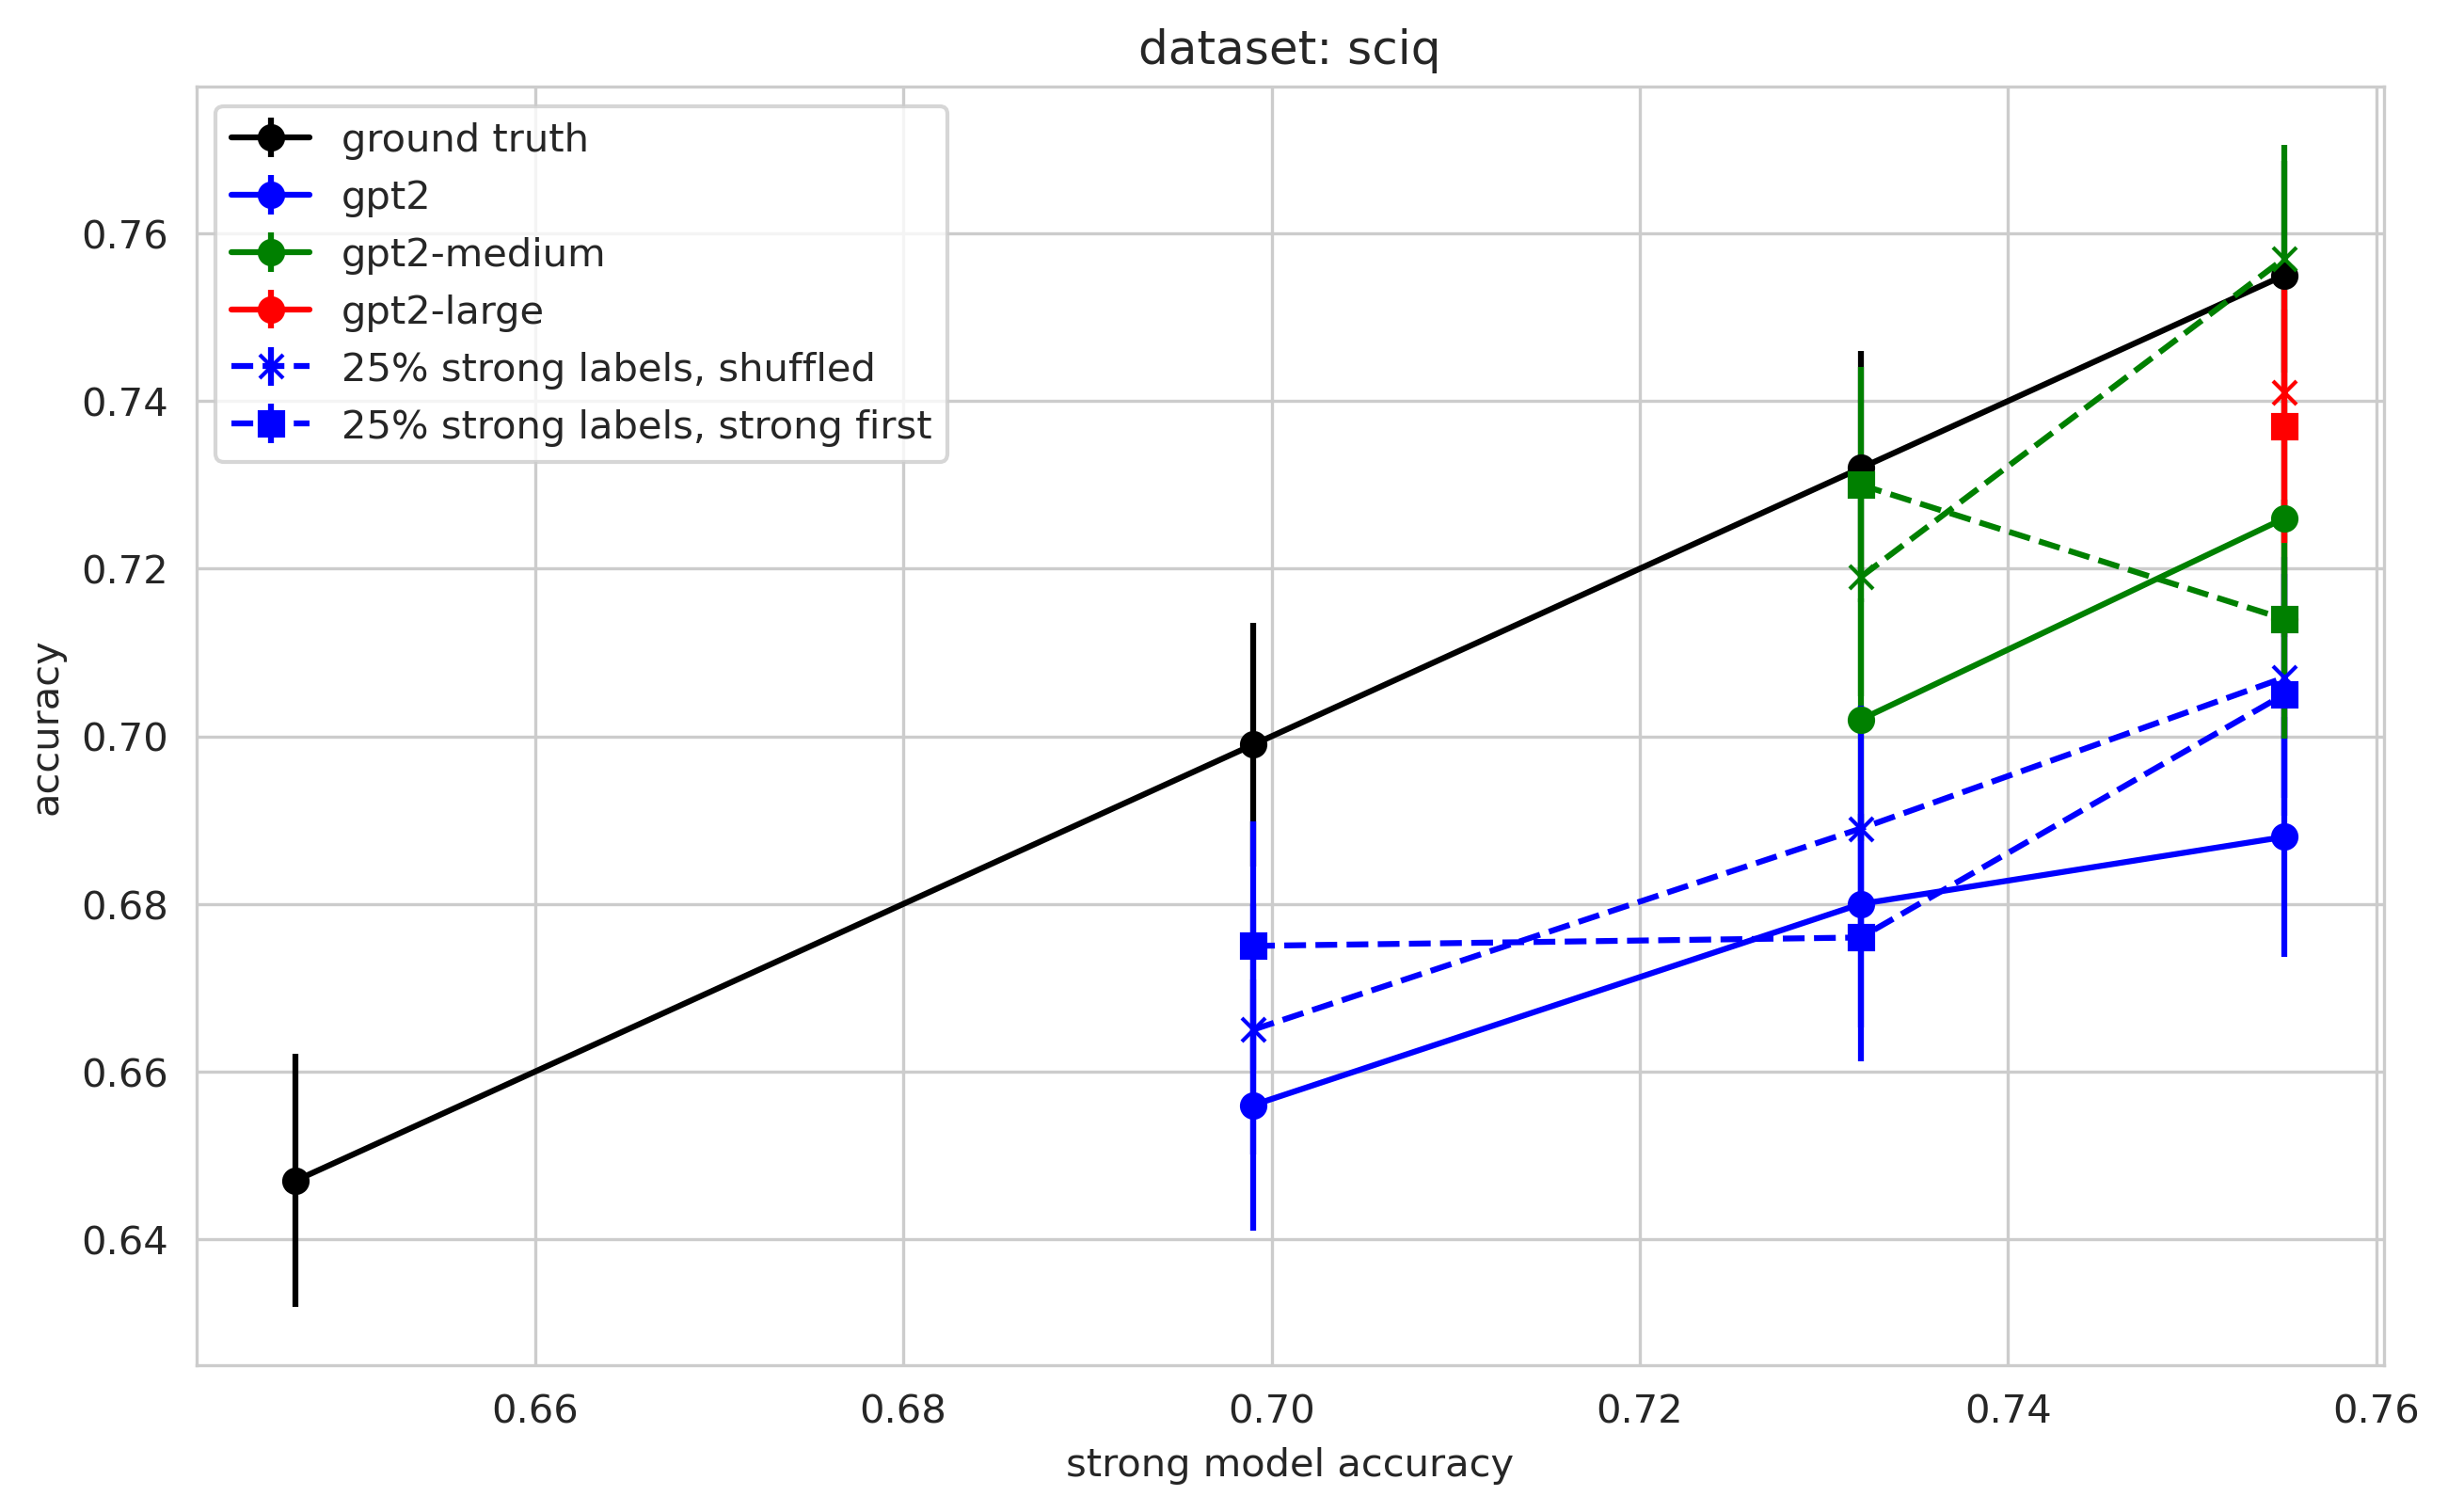

In [150]:
strong_model_accuracies, strong_model_stderrs = [], []
for model in MODELS_TO_PLOT:
    strong_model_accuracies.append(df[(df.model_size == model) & (df.weak_model_size.isna())].accuracy.mean())
    strong_model_stderrs.append(df[(df.model_size == model) & (df.weak_model_size.isna())].stderr.mean())
gpt2_wm_accuracies, gpt2_wm_stderrs = [0.656, 0.68, 0.688], [0.015022, 0.014751, 0.014290]
gpt2_med_wm_accuracies, gpt2_med_wm_stderrs = [0.702, 0.726], [0.014464, 0.014104]
gpt2_large_wm_accuracies, gpt2_large_wm_stderrs = [0.714], [0.014290]
gpt2_wm_shuffled_accuracies, gpt2_wm_shuffled_stderrs = [0.665, 0.689, 0.707], [0.014926, 0.014638, 0.014393]
gpt2_med_wm_shuffled_accuracies, gpt2_med_wm_shuffled_stderrs = [0.719, 0.757], [0.014214, 0.013563]
gpt2_large_wm_shuffled_accuracies, gpt2_large_wm_shuffled_stderrs = [0.741], [0.013853]
gpt2_wm_stw_accuracies, gpt2_wm_stw_stderrs = [0.675, 0.676, 0.705], [0.014811, 0.014799, 0.014421]
gpt2_med_wm_stw_accuracies, gpt2_med_wm_stw_stderrs = [0.730, 0.714], [0.014039, 0.014290]
gpt2_large_wm_stw_accuracies, gpt2_large_wm_stw_stderrs = [0.737], [0.013922]

fig = plt.figure(dpi=300, figsize=(10, 6))
plt.errorbar(strong_model_accuracies, strong_model_accuracies, yerr=strong_model_stderrs, color="black", marker='o', label="ground truth")
plt.errorbar(strong_model_accuracies[1:], gpt2_wm_accuracies, yerr=gpt2_wm_stderrs, color="blue", marker='o', label="gpt2")
plt.errorbar(strong_model_accuracies[2:], gpt2_med_wm_accuracies, yerr=gpt2_med_wm_stderrs, color="green", marker='o', label="gpt2-medium")
plt.errorbar(strong_model_accuracies[3:], gpt2_large_wm_accuracies, yerr=gpt2_large_wm_stderrs, color="red", marker='o', label="gpt2-large")
plt.errorbar(strong_model_accuracies[1:], gpt2_wm_shuffled_accuracies, yerr=gpt2_wm_shuffled_stderrs, color="blue", marker='x', linestyle='--', label="25% strong labels, shuffled")
plt.errorbar(strong_model_accuracies[2:], gpt2_med_wm_shuffled_accuracies, yerr=gpt2_med_wm_shuffled_stderrs, color="green", marker='x', linestyle='--')
plt.errorbar(strong_model_accuracies[3:], gpt2_large_wm_shuffled_accuracies, yerr=gpt2_large_wm_shuffled_stderrs, color="red", marker='x', linestyle='--')
plt.errorbar(strong_model_accuracies[1:], gpt2_wm_stw_accuracies, yerr=gpt2_wm_stw_stderrs, color="blue", marker='s', linestyle='--', label="25% strong labels, strong first")
plt.errorbar(strong_model_accuracies[2:], gpt2_med_wm_stw_accuracies, yerr=gpt2_med_wm_stw_stderrs, color="green", marker='s', linestyle='--')
plt.errorbar(strong_model_accuracies[3:], gpt2_large_wm_stw_accuracies, yerr=gpt2_large_wm_stw_stderrs, color="red", marker='s', linestyle='--')
plt.ylabel("accuracy")
plt.xlabel("strong model accuracy")
plt.legend()
plt.title("dataset: sciq")

Dataset: sciq (seed: None)


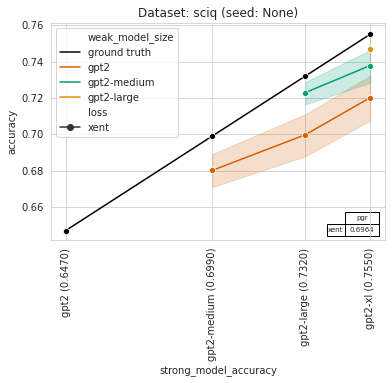

In [128]:
datasets = df.ds_name.unique()
for dataset in datasets:
    cur_df = df[(df.ds_name == dataset)].copy()
    base_accuracies = cur_df[cur_df['weak_model_size'].isna()].groupby('model_size').agg({'accuracy': 'mean', 'seed': 'count'}).sort_values('accuracy')
    base_accuracy_lookup = base_accuracies['accuracy'].to_dict()
    base_accuracies = base_accuracies.reset_index()

    cur_df['strong_model_accuracy'] = cur_df['model_size'].apply(lambda x: base_accuracy_lookup[x])
    cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_accuracy'] = cur_df.loc[~cur_df['weak_model_size'].isna(), 'weak_model_size'].apply(lambda x: base_accuracy_lookup[x])

    # Exclude cases where the weak model is better than the strong model from PGR calculation.
    valid_pgr_index = (
        (~cur_df['weak_model_size'].isna()) & 
        (cur_df['weak_model_size'] != cur_df['model_size']) & 
        (cur_df['strong_model_accuracy'] > cur_df['weak_model_accuracy'])
    )
    cur_df.loc[valid_pgr_index, 'pgr'] = (cur_df.loc[valid_pgr_index, 'accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy']) / (cur_df.loc[valid_pgr_index, 'strong_model_accuracy'] - cur_df.loc[valid_pgr_index, 'weak_model_accuracy'])

    cur_df.loc[cur_df['weak_model_size'].isna(), "weak_model_size"] = "ground truth"

    for seed in [None] + (sorted(cur_df['seed'].unique().tolist()) if PLOT_ALL_SEEDS else []):
        plot_df = cur_df.copy().sort_values(['strong_model_accuracy']).sort_values(['loss'], ascending=False)
        if seed is not None:
            plot_df = plot_df[plot_df['seed'] == seed]

        print(f"Dataset: {dataset} (seed: {seed})")

        pgr_results = plot_df[~plot_df['pgr'].isna()].groupby(['loss']).aggregate({"pgr": "median"})

        palette = sns.color_palette('colorblind', n_colors=len(plot_df['weak_model_size'].unique()))
        color_dict = {model: ("black" if model == 'ground truth' else palette.pop()) for model in plot_df['weak_model_size'].unique()}

        sns.lineplot(data=plot_df, x='strong_model_accuracy', y='accuracy', hue='weak_model_size', style='loss', markers=True, palette=color_dict)
        pd.plotting.table(plt.gca(), pgr_results.round(4), loc='lower right', colWidths=[0.1, 0.1], cellLoc='center', rowLoc='center')
        plt.xticks(ticks=base_accuracies['accuracy'], labels=[f"{e} ({base_accuracy_lookup[e]:.4f})" for e in base_accuracies['model_size']], rotation=90)
        plt.title(f"Dataset: {dataset} (seed: {seed})")
        plt.legend(loc='upper left')
        suffix = ""
        if seed is not None:
            suffix = f"_{seed}"
        plt.savefig(f"{dataset.replace('/', '-')}{suffix}.png", dpi=300, bbox_inches='tight')
        plt.show()

Text(0.5, 1.0, 'dataset: sciq')

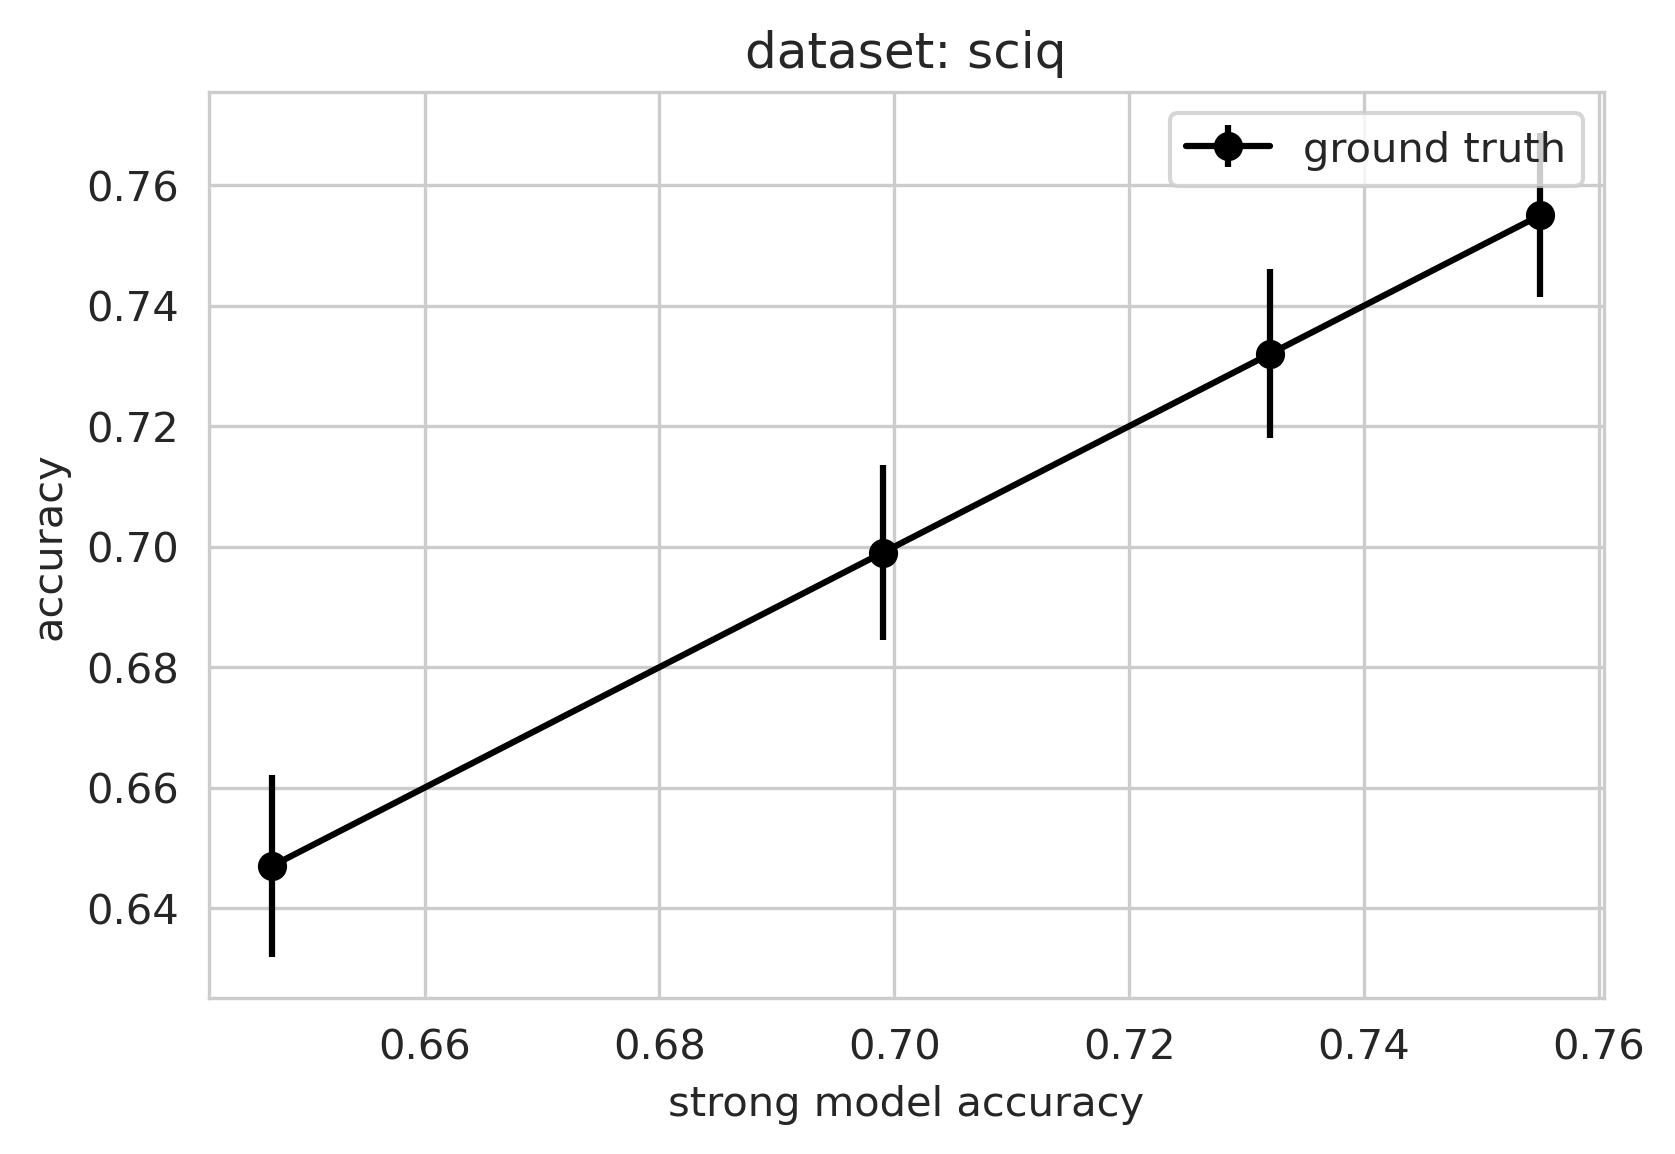

Text(0.5, 1.0, 'accuracy vs. strong label fraction, dataset: sciq')

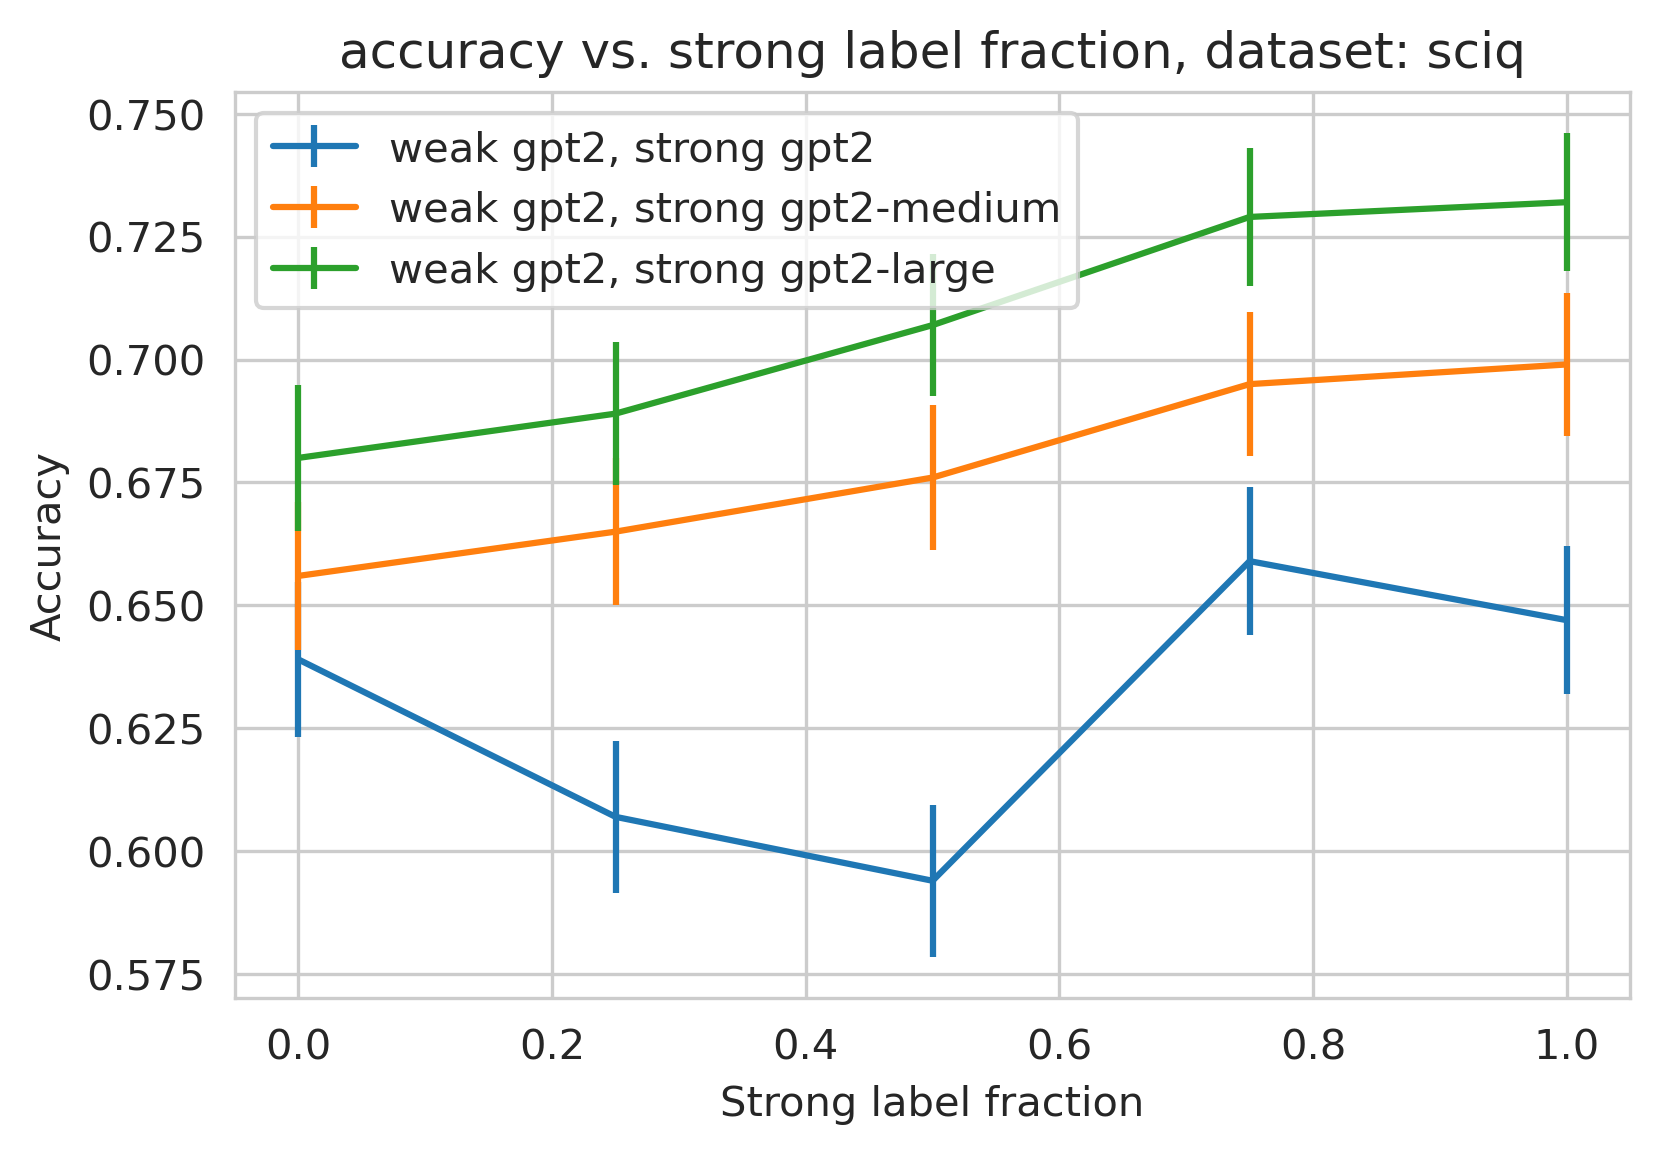

In [24]:
strong_label_fractions = [0, 0.25, 0.5, 0.75, 1]
gpt2_gpt2 = [0.639, 0.607, 0.594, 0.659, 0.647]
gpt_gp2_errs = [0.0158, 0.0154, 0.0155, 0.015, 0.0151]
gpt2_gpt2medium = [0.656, 0.665, 0.676, 0.695, 0.699]
gpt2_gpt2medium_errs = [0.015, 0.0149, 0.0148, 0.0146, 0.0145]
gpt2_gpt2large = [0.68, 0.689, 0.707, 0.729, 0.732]
gpt2_gpt2large_errs = [0.0148, 0.0146, 0.0144, 0.014, 0.014]

fig = plt.figure(dpi=300)
plt.errorbar(strong_label_fractions, gpt2_gpt2, yerr=gpt_gp2_errs, label='weak gpt2, strong gpt2')
plt.errorbar(strong_label_fractions, gpt2_gpt2medium, yerr=gpt2_gpt2medium_errs, label='weak gpt2, strong gpt2-medium')
plt.errorbar(strong_label_fractions, gpt2_gpt2large, yerr=gpt2_gpt2large_errs, label='weak gpt2, strong gpt2-large')
plt.xlabel('Strong label fraction')
plt.ylabel('Accuracy')
plt.legend()
plt.title('accuracy vs. strong label fraction, dataset: sciq')


KeyError: "None of [Index(['gpt2', 'gpt2-large', 'gpt2-large', 'gpt2-large', 'gpt2-large',\n       'gpt2-large', 'gpt2-medium', 'gpt2-medium', 'gpt2-medium',\n       'gpt2-medium', 'gpt2-xl', 'gpt2-xl', 'gpt2-xl', 'gpt2-xl', 'gpt2-xl',\n       'gpt2-xl', 'gpt2-xl'],\n      dtype='object')] are in the [columns]"